# Titanlib nebelhorn data

### Table of Contents  
- [Load in data](#Load-in-data)
- [Make a titanlib point](#Make-a-titanlib-point)
- [Make a dataset](#Make-a-dataset)
- [Buddy check](#Buddy-check)
- [Buddy event check](#Buddy-event-check)
- [Climatology range check](#Climatology-range-check)
- [First guess test](#First-guess-test)
- [Isolation check](#Isolation-check)
- [Metadata check](#Metadata-check)
- [Plotting wx station data](#Plotting-wx-station-data)
- [Range check](#Range-check)
- [Spatial consistency test](#Spatial-consistency-test)
- [Spatial consistency test resistant](#Spatial-consistency-test-resistant)
- [Spatial consistency test dual](#Spatial-consistency-test-dual)
- [Plotting temporal data](#Plotting-temporal-data)




## Load in data
At this stage I am just doing at one timestamp
I picked a time that had a lot of measurements

In [1]:
## Read in nebelhorn data into dataframe

import xarray as xr
import pandas as pd
import os
import numpy as np

# Folder containing files
folder_path = "/home/pcuser/titanlib/notebooks/nebelhorn"

# Define the target timestamp - I need to iterate though these in the future. 
# Best Time: 2022-01-22 12:00:00 with 94 stations having data

target_time = pd.to_datetime("2022-01-22T12:00:00")


# List to store extracted data
data_list = []

# Loop through all NetCDF files in the folder
for file in os.listdir(folder_path):
    if file.endswith(".nc"):
        file_path = os.path.join(folder_path, file)
        
        # Open the NetCDF file
        ds = xr.open_dataset(file_path)
        
        # Extract station name (assuming it's in the filename)
        station_name = file.split(".nc")[0] 
        
        # Convert time if it is stored as "hours since X"
        if np.issubdtype(ds.time.dtype, np.integer) or np.issubdtype(ds.time.dtype, np.floating):
            try:
                ds["time"] = xr.decode_cf(ds).time  # Automatically converts "hours since X" format
            except Exception:
                print(f"Warning: Could not auto-decode time for {file}")
        
        # Ensure time is in datetime64 format
        ds["time"] = pd.to_datetime(ds["time"].values)
        
        # Select the nearest time
        ds = ds.sel(time=target_time, method="nearest")

        # Extract variables (modify as needed)
        temp = ds.get("temp", None)
        rel_hum = ds.get("rel_hum", None)
        wind_speed = ds.get("wind_speed", None)
        wind_dir = ds.get("wind_dir", None)
        lat = ds.get("lat", None)
        lon = ds.get("lon", None)
        alt = ds.get("alt", None)

      #  print(f"Variables in {file}: {list(ds.variables.keys())}")
      #  print("Temp is: ", temp.values if temp is not None else "None")

        # Store extracted data
        data_list.append({
            "Station": station_name,
            "Time": str(ds.time.values),
            "Temperature": float(temp.values) if temp is not None else None,
            "RH": float(rel_hum.values) if rel_hum is not None else None,
#            "Wind Speed": float(wind_speed.values) if wind_speed is not None else None,  Don't really need to QC these
#            "Wind Dir": float(wind_dir.values) if wind_speed is not None else None,
            "Latitude": float(lat.values) if lat is not None else None,
            "Longitude": float(lon.values) if lon is not None else None,
            "Altitude": float(alt.values) if alt is not None else None,
        })
        
        ds.close()

# Convert to Pandas DataFrame for easy comparison
df = pd.DataFrame(data_list)
# Display the DataFrame
print(df.head())

             Station                           Time  Temperature         RH  \
0    nebelhorn-pit_3  2022-01-22T12:00:00.000000000          NaN        NaN   
1  nebelhorn-pit_116  2022-01-22T12:00:00.000000000   271.133333  94.283333   
2  nebelhorn-pit_305  2022-01-22T12:00:00.000000000          NaN        NaN   
3  nebelhorn-pit_209  2022-01-22T12:00:00.000000000          NaN        NaN   
4  nebelhorn-pit_119  2022-01-22T12:00:00.000000000   271.225000  92.450000   

    Latitude  Longitude     Altitude  
0  47.409702  10.315118  1335.480957  
1  47.410301  10.296711  1025.077026  
2  47.412685  10.345387  1911.375977  
3  47.408394  10.326666  1395.333008  
4  47.408539  10.295107   976.849976  


## Make a titanlib point

In [2]:

import titanlib

# Extract the relevant columns
latitude = df['Latitude'].values
longitude = df['Longitude'].values
altitude = df['Altitude'].values
temperature = df['Temperature'].values  # Observations (e.g., temperature)

# Create TitanLib Points object
points = titanlib.Points(latitude, longitude, altitude)


# Metadata check flags stations with invalid latitude, longitude, and/or elevations.
# This is currently just flagging stations with no data
flags = titanlib.metadata_check(
    points, True, True, True, True
)

print(flags)



[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Make a dataset

In [3]:

tmin = np.full(points.size(), -253) #I need to think about what temps are useful, also alot of these flags are just a lack of data
tmax = np.full(points.size(), 300)
radius = 1500000 # m
nb_neigh = 1


dataset = titanlib.Dataset(points, temperature)

print(dataset)
## This is a way that titanlib manages multiple checks preverving the flags.
## First range_check then isolation_check


dataset.range_check(tmin, tmax)
print(dataset.get_flags())

dataset.isolation_check(nb_neigh, radius)
print(dataset.get_flags())




<titanlib.Dataset; proxy of <Swig Object of type 'titanlib::Dataset *' at 0x7fa96c5611b0> >
[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]
[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]


## Buddy check

In [4]:

#Buddy check 


radius = np.full(points.size(), 5000)
num_min = np.full(points.size(), 1)
threshold = 2
max_elev_diff = 200
elev_gradient = -0.0065
min_std = 1
num_iterations = 5

flags = titanlib.buddy_check(
    points,
    temperature,
    radius,
    num_min,
    threshold,
    max_elev_diff,
    elev_gradient,
    min_std,
    num_iterations,
)

print(flags)
print(num_min)

[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Buddy event check  

In [5]:
#Buddy event check

radius = np.full(points.size(), 5000)
num_min = np.full(points.size(), 1)
event_threshold = 0.2
threshold = 0.25
max_elev_diff = 10
elev_gradient = 0
num_iterations = 5
flags = titanlib.buddy_event_check(points, temperature, radius, num_min,
            event_threshold, threshold, max_elev_diff, elev_gradient, num_iterations)

print(flags)

[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]


## Plotting wx station data

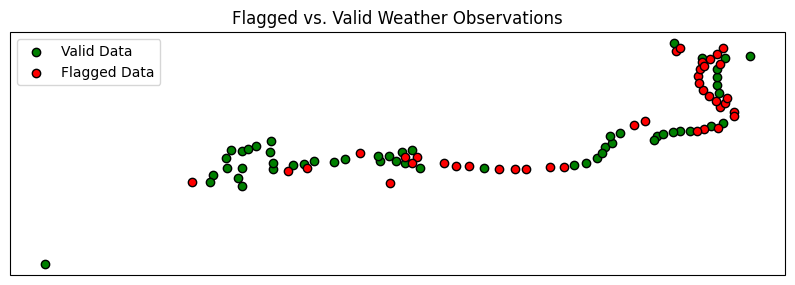

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Extract flagged and unflagged indices
flagged_indices = np.where(flags != 0)[0]  # Flags that are not 0 (invalid)
unflagged_indices = np.where(flags == 0)[0]  # Valid data points

# Create a map
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add map features
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.COASTLINE)

# Plot valid observations (green)
ax.scatter(
    longitude[unflagged_indices], latitude[unflagged_indices],
    c="green", label="Valid Data", edgecolors="black", transform=ccrs.PlateCarree()
)

# Plot flagged observations (red)
ax.scatter(
    longitude[flagged_indices], latitude[flagged_indices],
    c="red", label="Flagged Data", edgecolors="black", transform=ccrs.PlateCarree()
)

# Add title & legend
ax.set_title("Flagged vs. Valid Weather Observations")
ax.legend()

# Show the map
plt.show()

## Climatology range check  

In [7]:
#Range check climatology
target_time = pd.to_datetime("2022-01-22T12:00:00")


unixtime = int(target_time.timestamp()) #need this as input for climatology 
tpos = np.full(points.size(), 300)
tneg = np.full(points.size(), 250)

flags = titanlib.range_check_climatology(points, temperature, unixtime, tpos, tneg)   #this climatology might be in C we are in K
print(flags)

[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]


## Isolation check

In [8]:
radius = 1500 # m
nb_neigh = 10


flags = titanlib.isolation_check(points, nb_neigh, radius)
print(flags)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


## Metadata check

What is this actually checking, I thought it was that the lats/lons are good.

In [9]:
flags = titanlib.metadata_check(points, True, True, True, True)
print(flags)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Range check

In [10]:
nb_neigh = 1
radius = 20

tpos = np.full(points.size(), 300)
tneg = np.full(points.size(), 250)

flags = titanlib.range_check(temperature, tneg, tpos)
print(flags)



[1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1]


## Spatial consistency test 

In [17]:
pos = np.full(points.size(), 4)
neg = np.full(points.size(), 8)
eps2 = np.full(points.size(), 0.5)

dataset.sct(
    5,      # num_min
    100,    # num_max
    50000,  # inner_radius
    150000, # outer_radius
    5,      # num_iterations
    20,     # num_min_prof
    200,    # min_elev_diff
    10000,  # min_horizonal_scale
    200,    # vertical_scale
    pos,
    neg,
    eps2)

print(dataset.get_flags())

[1 0 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 1 0 0
 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1]


<div class="alert alert-danger"> 
Kernel keeps crashing if I run this on points, seems to work better as a dataset

In [ ]:
## Spatial consistency test - Returned parameters Quality control flag (0=OK, 1=bad), 
# prob_gross_error	vec		Probability of gross error for each observation
# rep	vec		Coefficient of representativity

pos = np.full(points.size(), 4)
neg = np.full(points.size(), 8)
eps2 = np.full(points.size(), 0.5)

flags, prob, rep = titanlib.sct(points,
    temperature,
    5,      # num_min
    100,    # num_max
    50000,  # inner_radius
    150000, # outer_radius
    1,      # num_iterations
    20,     # num_min_prof
    200,    # min_elev_diff
    10000,  # min_horizonal_scale
    200,    # vertical_scale
    pos,
    neg,
    eps2)

print(flags)
print(prob)
print(rep)

## Spatial consistency test resistant

In [ ]:
## Spatial consistency test Resistant

pos = np.full(points.size(), 4)
neg = np.full(points.size(), 8)
eps2 = np.full(points.size(), 0.5)

obs_to_check = np.full(points.size(), 1)
background_values = np.full(points.size(), 0)
background_elab_type = titanlib.MedianOuterCircle
num_min_outer = 3
num_max_outer = 10
inner_radius = 20000
outer_radius = 50000
num_iterations = 10
num_min_prof = 1
min_elev_diff = 100
min_horizontal_scale = 250 
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
vertical_scale = 200
tpos = np.full(points.size(), 16)
tneg = np.full(points.size(), 16)
eps2 = np.full(points.size(), 0.5)
values_mina = np.full(points.size(), -20)
values_maxa = np.full(points.size(), 20)
values_minv = np.full(points.size(), 0)
values_maxv = np.full(points.size(), 10)
debug = True
basic = True


flags, scores = titanlib.sct_resistant( points, observations, obs_to_check, background_values, 
                      background_elab_type, num_min_outer, num_max_outer, 
                      inner_radius, outer_radius, num_iterations, num_min_prof, 
                      min_elev_diff, min_horizontal_scale, max_horizontal_scale, 
                      kth_closest_obs_horizontal_scale, vertical_scale, 
                      values_mina, values_maxa, values_minv, values_maxv, 
                      eps2, tpos, tneg, debug, basic)

## First guess test

In [20]:
## Now we test on our nebelhorn data

N = len(latitude)
obs_to_check = np.ones(N)
background_values = np.zeros(N)
background_uncertainties = np.ones(N)
background_elab_type = titanlib.MedianOuterCircle
num_min_outer = 3
num_max_outer = 10
inner_radius = 20000
outer_radius = 50000
num_iterations = 10
num_min_prof = 0
min_elev_diff = 100
min_horizontal_scale = 250
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
tpos = np.ones(N) * 5
tneg = np.ones(N) * 5
values_mina = temperature - 20
values_maxa = temperature + 20
values_minv = temperature - 1
values_maxv = temperature + 1
debug = True
basic = True
print("Starting FGT function with debug=True")
print(f"Debug mode is set to: {debug}")

res = titanlib.fgt(points, temperature, obs_to_check,
    background_values, 
    background_uncertainties, 
    background_elab_type, 
    num_min_outer, 
    num_max_outer, 
    inner_radius, 
    outer_radius, 
    num_iterations, 
    num_min_prof, 
    min_elev_diff, 
    values_mina, 
    values_maxa, 
    values_minv, 
    values_maxv, 
    tpos, 
    tneg, 
    debug, 
    basic   
)

print(res)

Starting FGT function with debug=True
Debug mode is set to: True
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32), array([-999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., -999., -999., -999., -999.,
       -999., -999., -999., -999., -999., 

## Spatial consistency test dual

<div class="alert alert-danger"> 
I haven't gotten this test working

In [29]:
N = len(lats)
obs_to_check = np.ones(N)
event_thresholds = 0.1
test_thresholds = 0.8
#condition = titanlib.Gt

condition = titanlib.MedianOuterCircle

num_min_outer = 3
num_max_outer = 10
inner_radius = 20000
outer_radius = 50000
num_iterations = 10
min_horizontal_scale = 250 
max_horizontal_scale = 100000
kth_closest_obs_horizontal_scale = 2
vertical_scale = 200
debug = True
titanlib.sct_dual(points, temp_obs, obs_to_check, event_thresholds, condition,
                 num_min_outer, num_max_outer, inner_radius, outer_radius,
                 num_iterations, min_horizontal_scale, max_horizontal_scale,
                 kth_closest_obs_horizontal_scale, vertical_scale,
                 test_thresholds, debug)

TypeError: Could not convert input to 1D array of type 'float'

## Plotting temporal data

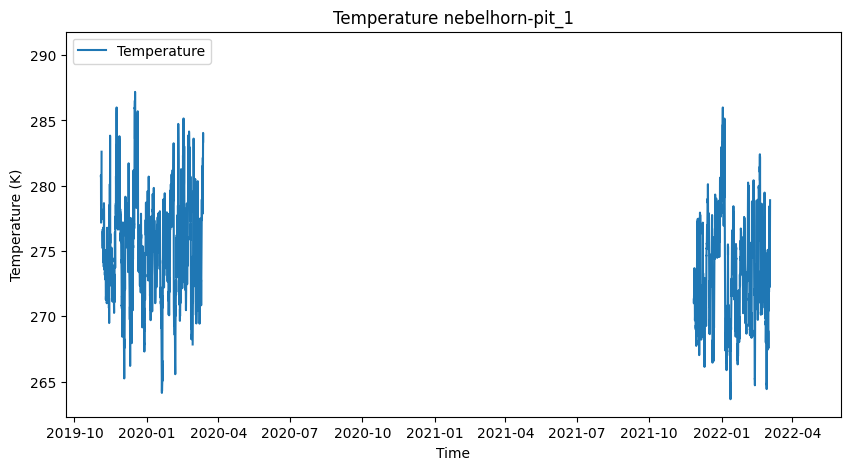

In [18]:
#Plotting time series of snowgun data
import netCDF4 as nc 
import xarray as xr   
import numpy as np    
import matplotlib.pyplot as plt  


# Enable inline plotting in Jupyter
%matplotlib inline


file_path = "/mnt/c/Users/c707165/Documents/Schneeprophet/Data_cleaning/nebelhorn/nebelhorn-pit_1.nc"
dataset = nc.Dataset(file_path, mode='r')

# Print metadata
# print(dataset)
ds = xr.open_dataset(file_path)
# print(ds)
# print(dataset.variables.keys())  # For netCDF4
# print(ds.variables)  # For xarray
temperature = ds['temp'].values  # Extract temperature data
time = ds['time'].values  # Extract time data

plt.figure(figsize=(10, 5))
plt.plot(time, temperature, label="Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature (K)")
plt.title("Temperature "+os.path.splitext(os.path.basename(file_path))[0])
plt.legend()
plt.show()

Output from interrupted FGT test

Starting FGT function with debug=True
Debug mode is set to: True
mean t: 0.528034
mean t: 0.527295
mean t: 0.524355
mean t: 0.529648
mean t: 0.529469
mean t: 0.529615
mean t: 0.523823
mean t: 0.519288
mean t: 0.526585
mean t: 0.529445
mean t: 0.525324
mean t: 0.522167
mean t: 0.518671
mean t: 0.529488
mean t: 0.522732
mean t: 0.517448
mean t: 0.527888
mean t: 0.526726
mean t: 0.523592
mean t: 0.524637
mean t: 0.523319
mean t: 0.529271
mean t: 0.52156
mean t: 0.524628
mean t: 0.529389
mean t: 0.526274
mean t: 0.513901
mean t: 0.530419
mean t: 0.528777
mean t: 0.528589
mean t: 0.531398
mean t: 0.51662
mean t: 0.527408
mean t: 0.528217
mean t: 0.514668
mean t: 0.528791
mean t: 0.529111
mean t: 0.531308
mean t: 0.529855
mean t: 0.52506
mean t: 0.513204
mean t: 0.529488
mean t: 0.517679
mean t: 0.52109
mean t: 0.528918
mean t: 0.51486
mean t: 0.530777
mean t: 0.527145
mean t: 0.520337
mean t: 0.524214
mean t: 0.524929
mean t: 0.531271
mean t: 0.528805
mean t: 0.515213
mean t: 0.52586
mean t

KeyboardInterrupt: 

-999
1 85 47.4084 10.3238 -nan -999
2 77 47.4087 10.3206 -nan -999
3 21 47.4087 10.3193 -nan -999
4 59 47.4084 10.3254 -nan -999
5 35 47.4091 10.318 -nan 0
6 3 47.4084 10.3267 -nan -999
7 41 47.4085 10.3155 271.325 0
8 24 47.4086 10.3292 -nan -999
9 0 47.4097 10.3151 -nan 0
outer - i lats lons obs:
0 47.4086 10.3222 272.058 -999
1 47.4084 10.3238 -nan -999
2 47.4087 10.3206 -nan -999
3 47.4087 10.3193 -nan -999
4 47.4084 10.3254 -nan -999
5 47.4091 10.318 -nan 0
6 47.4084 10.3267 -nan -999
7 47.4085 10.3155 271.325 0
8 47.4086 10.3292 -nan -999
9 47.4097 10.3151 -nan 0
indices_outer_inner - l i lats lons obs:
0 0 47.4086 10.3222 272.058 -999
1 1 47.4084 10.3238 -nan -999
2 2 47.4087 10.3206 -nan -999
3 3 47.4087 10.3193 -nan -999
4 4 47.4084 10.3254 -nan -999
5 5 47.4091 10.318 -nan 0
6 6 47.4084 10.3267 -nan -999
7 7 47.4085 10.3155 271.325 0
8 8 47.4086 10.3292 -nan -999
9 9 47.4097 10.3151 -nan 0
indices_outer_test - l m lats lons obs:
0 0 47.4086 10.3222 272.058 -999
1 1 47.4084 10